In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Lab 1

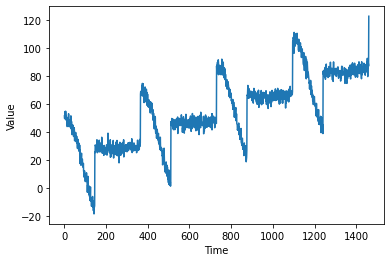

In [66]:
# UTILITIES
def plot_series(time, series, labels=None, format="-", start=0, end=None):
  if type(series) is tuple:
    for s in series:
      plt.plot(time[start:end], s[start:end], format)
    plt.legend(labels)
  else:
    plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.show()

def trend(time, slope):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(2*np.pi*season_time),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period) / period
  return seasonal_pattern(season_time) * amplitude

def noise(time, noise_level, seed):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

# GENERATE DATA
def generate_time_series(slope, period, amplitude, noise_level, seed):
  time = np.arange(365*4+1, dtype="float32")
  series = 10 + trend(time, slope)
  series += seasonality(time, period, amplitude)
  series += noise(time, noise_level, seed)
  return time, series 

time, series = generate_time_series(0.05, 365, 40, 3, 42)
plot_series(time, series)

In [11]:
def train_val_split(time, series, split_size):
  x_train = series[:split_size]
  x_test = series[split_size:]
  train_time = time[:split_size]
  test_time = time[split_size:]
  return x_train, x_test, train_time, test_time

x_train, x_test, train_time, test_time = train_val_split(time, series, 1000)

In [12]:
window_size = 20

def windowed_data(series):
  d = tf.data.Dataset.from_tensor_slices(series)
  d = d.window(window_size+1, shift=1, drop_remainder=True)
  d = d.flat_map(lambda w: w.batch(window_size+1))
  d = d.map(lambda w: (w[:-1], w[-1]))
  d = d.shuffle(1000)
  d = d.batch(32).prefetch(1)
  return d

train_set = windowed_data(x_train)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400),
])

In [15]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [17]:
model.compile(optimizer="sgd", loss=tf.keras.losses.Huber(), metrics=["mae"])
hist = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 7s 31ms/step - loss: 228.4064 - mae: 228.9063 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 2s 39ms/step - loss: 219.8101 - mae: 220.3101 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 208.5874 - mae: 209.0871 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 158.9064 - mae: 159.4060 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 125.5327 - mae: 126.0323 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 32ms/step - loss: 119.9468 - mae: 120.4464 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 114.8819 - mae: 115.3816 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 22ms/step - loss: 109.6245 - mae: 110.1241 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss

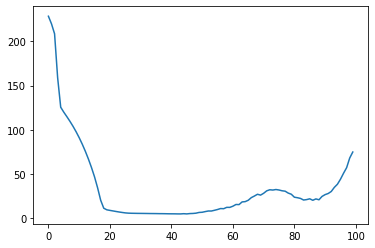

In [19]:
plt.plot(hist.history["loss"])

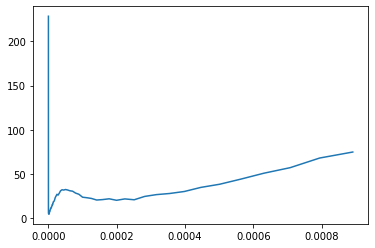

In [21]:
plt.plot(hist.history["lr"], hist.history["loss"])

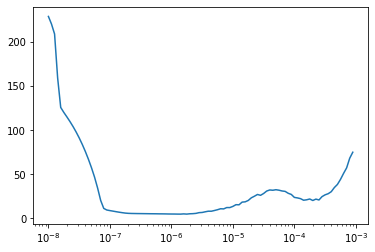

In [22]:
plt.semilogx(1e-8*10**(np.arange(100)/20), hist.history["loss"])

In [23]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400),
])

model2.compile(optimizer=tf.keras.optimizers.SGD(1e-6), loss=tf.keras.losses.Huber(), metrics=["mae"])
hist2 = model2.fit(train_set, epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 30ms/step - loss: 24.0299 - mae: 24.5242
Epoch 2/100
31/31 [==============================] - 1s 36ms/step - loss: 13.2451 - mae: 13.7309
Epoch 3/100
31/31 [==============================] - 2s 41ms/step - loss: 10.5331 - mae: 11.0160
Epoch 4/100
31/31 [==============================] - 1s 37ms/step - loss: 9.8698 - mae: 10.3514
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 9.4536 - mae: 9.9311
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 9.1585 - mae: 9.6377
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 8.8922 - mae: 9.3713
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 8.6075 - mae: 9.0835
Epoch 9/100
31/31 [==============================] - 1s 24ms/step - loss: 8.3272 - mae: 8.8033
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 8.0629 - mae: 8.5390
Epoch 11/100
31/31 [======================

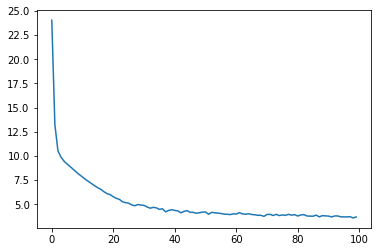

In [24]:
plt.plot(hist2.history["loss"])

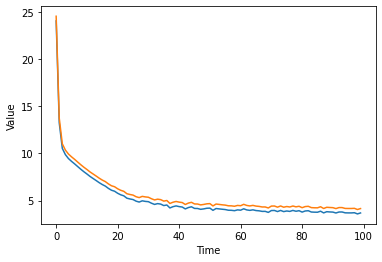

In [25]:
plot_series(np.arange(100), (hist2.history["loss"], hist2.history["mae"]))

In [27]:
def model_forecast(model, series, window_size, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  ds = ds.batch(batch_size).prefetch(1)
  f = model.predict(ds)
  return f

15/15 [==============================] - 2s 10ms/step


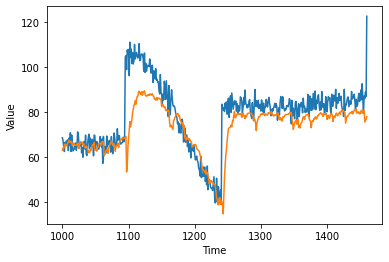

In [28]:
forecast_series = series[1000 - window_size: -1]
forecast = model_forecast(model2, forecast_series, 20, 32)
res = forecast.squeeze()

plot_series(test_time, (x_test, res))

In [30]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_test, res).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, res).numpy())

106.63786
6.802815


In [41]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, model, logs={}):
    if logs.get("val_mae") < 5.0:
      print("\nMae val is less than 5.0, so stopping training!")
      self.model.stop_training = True

callback = myCallback()

In [32]:
val_set = windowed_data(x_test)

In [42]:
model2.compile(optimizer=tf.keras.optimizers.SGD(1e-6), loss=tf.keras.losses.Huber(), metrics=["mae"])
hist3 = model2.fit(train_set, epochs=500, callbacks=[callback], validation_data=val_set)

Epoch 1/500
31/31 [==============================] - 6s 71ms/step - loss: 3.6974 - mae: 4.1669 - val_loss: 6.8649 - val_mae: 7.3493
Epoch 2/500
31/31 [==============================] - 1s 33ms/step - loss: 3.7050 - mae: 4.1708 - val_loss: 6.1942 - val_mae: 6.6749
Epoch 3/500
31/31 [==============================] - 1s 28ms/step - loss: 3.7162 - mae: 4.1847 - val_loss: 6.1503 - val_mae: 6.6291
Epoch 4/500
31/31 [==============================] - 1s 28ms/step - loss: 3.7348 - mae: 4.2037 - val_loss: 5.6501 - val_mae: 6.1327
Epoch 5/500
31/31 [==============================] - 1s 25ms/step - loss: 3.6580 - mae: 4.1263 - val_loss: 5.4029 - val_mae: 5.8796
Epoch 6/500
31/31 [==============================] - 1s 25ms/step - loss: 3.6644 - mae: 4.1322 - val_loss: 5.6547 - val_mae: 6.1371
Epoch 7/500
31/31 [==============================] - 1s 29ms/step - loss: 3.7361 - mae: 4.2027 - val_loss: 5.7354 - val_mae: 6.2153
Epoch 8/500
31/31 [==============================] - 1s 25ms/step - loss: 3.

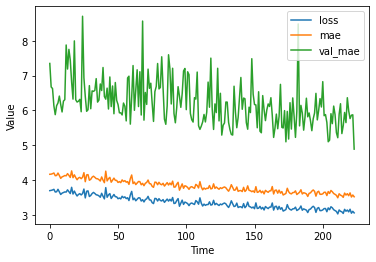

In [67]:
plot_series(np.arange(len(hist3.history["loss"])), (hist3.history["loss"], hist3.history["mae"], hist3.history["val_mae"]), labels=["loss", "mae", "val_mae"],)

# Lab 2 & 3

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf

In [69]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-10-15 15:12:45--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-10-15 15:12:45 (66.8 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [70]:
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


Text(0, 0.5, 'sunspot number')

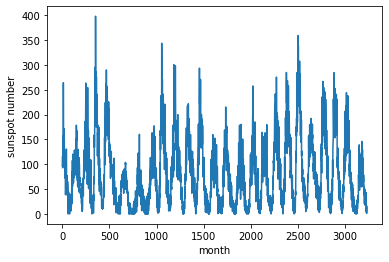

In [73]:
time_steps = []
sunspots = []

with open("/content/Sunspots.csv") as f:
  reader = csv.reader(f, delimiter=",")
  next(reader)
  for row in reader:
    time_steps.append(int(row[0]))
    sunspots.append(float(row[2]))

time = np.array(time_steps)
series = np.array(sunspots)

plt.plot(time, series)
plt.xlabel("month")
plt.ylabel("sunspot number")

In [74]:
split_time = 3000

x_train = series[:split_time]
x_test = series[split_time:]

train_time = time[:split_time]
test_time = time[split_time:]

In [75]:
train_set = windowed_data(x_train)
test_set = windowed_data(x_test)

In [84]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, input_shape=[window_size, 1], activation="relu", padding="causal"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400),
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

model_3.compile(optimizer="sgd", loss=tf.keras.losses.Huber(), metrics=["mae"]) 
hist4 = model_3.fit(train_set, epochs=100, callbacks=lr_scheduler)

Epoch 1/100
94/94 [==============================] - 7s 30ms/step - loss: 124.2127 - mae: 124.7120 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 3s 30ms/step - loss: 115.3152 - mae: 115.8140 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 104.2935 - mae: 104.7928 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 3s 28ms/step - loss: 92.4464 - mae: 92.9441 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 3s 31ms/step - loss: 82.2379 - mae: 82.7352 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 3s 31ms/step - loss: 73.9128 - mae: 74.4089 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 4s 43ms/step - loss: 67.2270 - mae: 67.7238 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 4s 41ms/step - loss: 61.6030 - mae: 62.0986 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 3s 27ms/step - loss: 57.0046 

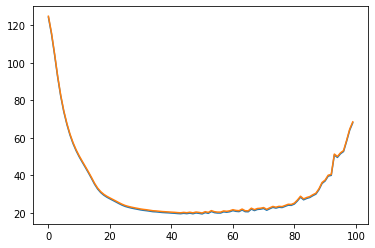

In [87]:
plt.plot(hist4.history["loss"])
plt.plot(hist4.history["mae"])

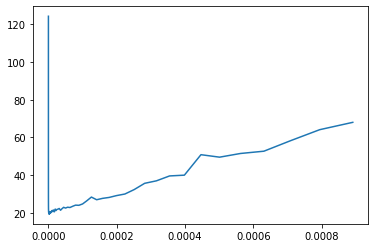

In [88]:
plt.plot(hist4.history["lr"], hist4.history["loss"])

In [90]:
np.argmin(hist4.history["loss"]), hist4.history["lr"][50] # best -> 3.1622776e-06

(50, 3.1622776e-06)

In [92]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),  input_shape=[window_size]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400),
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

model_4.compile(optimizer="sgd", loss=tf.keras.losses.Huber(), metrics=["mae"]) 
hist5 = model_4.fit(train_set, epochs=100, callbacks=lr_scheduler)

Epoch 1/100
94/94 [==============================] - 7s 28ms/step - loss: 57.5521 - mae: 58.0507 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 3s 27ms/step - loss: 56.3207 - mae: 56.8187 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 3s 27ms/step - loss: 55.0079 - mae: 55.5059 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 3s 27ms/step - loss: 53.5642 - mae: 54.0627 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 3s 28ms/step - loss: 51.9862 - mae: 52.4844 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 3s 26ms/step - loss: 50.3411 - mae: 50.8395 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 3s 26ms/step - loss: 48.5857 - mae: 49.0841 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 2s 25ms/step - loss: 46.7666 - mae: 47.2649 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 3s 25ms/step - loss: 44.9189 - mae:

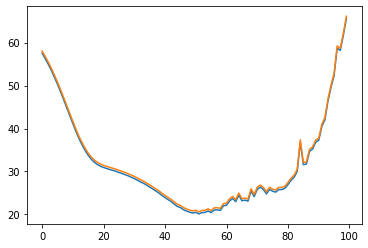

In [93]:
plt.plot(hist5.history["loss"])
plt.plot(hist5.history["mae"])

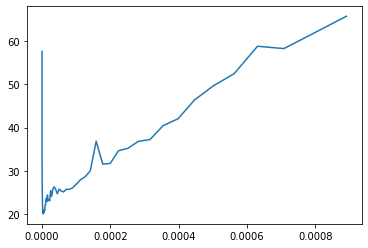

In [94]:
plt.plot(hist5.history["lr"], hist5.history["loss"])

In [96]:
tf.keras.backend.clear_session()

model_5 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),  input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400),
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

model_5.compile(optimizer="sgd", loss=tf.keras.losses.Huber(), metrics=["mae"]) 
hist6 = model_5.fit(train_set, epochs=100, callbacks=lr_scheduler)

Epoch 1/100
94/94 [==============================] - 14s 57ms/step - loss: 103.0532 - mae: 103.5519 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 5s 53ms/step - loss: 97.5409 - mae: 98.0390 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 5s 48ms/step - loss: 97.1108 - mae: 97.6102 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 5s 48ms/step - loss: 95.3725 - mae: 95.8713 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 5s 46ms/step - loss: 92.5704 - mae: 93.0679 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 5s 49ms/step - loss: 90.3431 - mae: 90.8417 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 5s 48ms/step - loss: 88.8162 - mae: 89.3146 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 5s 49ms/step - loss: 87.8859 - mae: 88.3840 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 5s 46ms/step - loss: 85.3210 - m

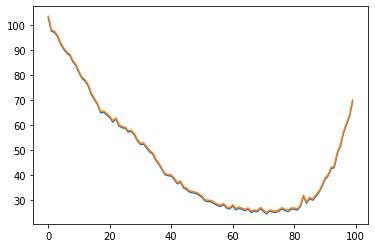

In [116]:
plt.plot(hist6.history["loss"])
plt.plot(hist6.history["mae"])

8/8 [==============================] - 0s 26ms/step


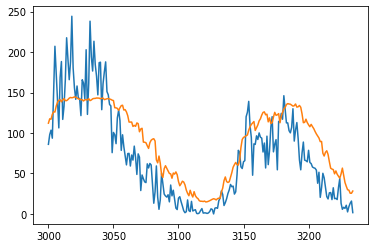

In [99]:
forecast_series = series[split_time - window_size: -1]
forecast = model_forecast(model_5, forecast_series, 20, 32)
res = forecast.squeeze()

plt.plot(test_time, x_test)
plt.plot(test_time, res)

## Decaying Learning Rate



```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)```



In [114]:
test_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [118]:
%%time

initial_lr = 1e-7

lr_s = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=400,
    decay_rate=0.95,
    staircase=True
)

opt = tf.keras.optimizers.SGD(learning_rate=lr_s)

model_5.compile(opt, loss=tf.keras.losses.Huber(), metrics=["mae"])
hist_7 = model_5.fit(train_set, epochs=70, validation_data=val_set)

Epoch 1/70
94/94 [==============================] - 19s 92ms/step - loss: 27.5167 - mae: 28.0118 - val_loss: 15.9277 - val_mae: 16.4245
Epoch 2/70
94/94 [==============================] - 7s 72ms/step - loss: 27.3302 - mae: 27.8257 - val_loss: 15.8763 - val_mae: 16.3733
Epoch 3/70
94/94 [==============================] - 7s 68ms/step - loss: 27.2699 - mae: 27.7647 - val_loss: 15.7856 - val_mae: 16.2831
Epoch 4/70
94/94 [==============================] - 5s 49ms/step - loss: 26.8696 - mae: 27.3645 - val_loss: 15.7385 - val_mae: 16.2363
Epoch 5/70
94/94 [==============================] - 5s 53ms/step - loss: 26.8135 - mae: 27.3092 - val_loss: 15.6869 - val_mae: 16.1849
Epoch 6/70
94/94 [==============================] - 5s 48ms/step - loss: 27.2044 - mae: 27.6984 - val_loss: 15.6237 - val_mae: 16.1219
Epoch 7/70
94/94 [==============================] - 4s 46ms/step - loss: 26.7610 - mae: 27.2564 - val_loss: 15.5575 - val_mae: 16.0559
Epoch 8/70
94/94 [==============================] - 5s

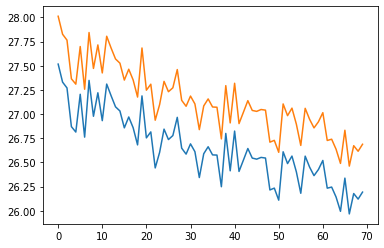

In [121]:
plt.plot(hist_7.history["loss"])
plt.plot(hist_7.history["mae"])

8/8 [==============================] - 2s 22ms/step


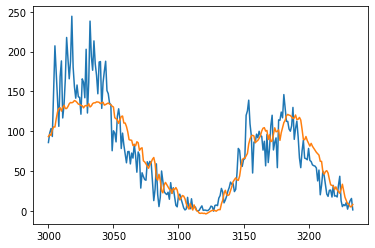

In [122]:
f_series = series[split_time - window_size: -1]
f = model_forecast(model_5, f_series, 20, 32)
res = f.squeeze()

plt.plot(test_time, x_test)
plt.plot(test_time, res)

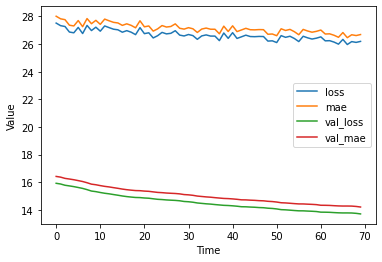

In [123]:
plot_series(np.arange(len(hist_7.history["loss"])), (hist_7.history["loss"], hist_7.history["mae"], hist_7.history["val_loss"], hist_7.history["val_mae"]), labels=["loss", "mae", "val_loss" ,"val_mae"],)

In [125]:
tf.keras.metrics.mean_absolute_error(x_test, res).numpy()

19.989225

In [127]:
tf.keras.metrics.mean_squared_error(x_test, res).numpy()

776.4168